In [3]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass


import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, RadioMaterial, LambertianPattern
from ris import RIS
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, cir_to_time_channel
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.constants import PI, SPEED_OF_LIGHT
import mplcursors


In [165]:
scene = load_scene(sionna.rt.scene.simple_reflector)

Define the configuration of TX and RX using PlanarArray. 
Note: this would create any Tx or Rx in the scene; to put any Tx or Rx in the scene we should use Transmitter and Receiver to create them and then use secen.add to add them to the scene.


The carrier frequesncy has to be in the Frequency range of the radio material of the environment; otherwise it would give you an error saying the radio_material is not well-defined.

In [166]:
scene.remove("tx")
scene.remove("rx")
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

dist = 5
d = dist/np.sqrt(2)

tx = Transmitter(name="tx", position=[-d,0,d])
scene.add(tx)

rx = Receiver(name="rx", position=[d,0,d], orientation=[0,0,0])
scene.add(rx)
tx.look_at(rx) 

scene.frequency = 2.4e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True 

scene.get("reflector").radio_material.scattering_coefficient = 0.5

In [167]:
subcarrier_spacing = 300e3
fft_size = 64
frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)

Define the antenna array in the RIS and then create it usinf the RIS command. There is no need to add this to the scene(yet).
Make sure that tx_to_ris_env and rx_to_ris_env are both set to be True, otherwise the effect of RIS would diminish. These two make sure that reflection and scattering are considered while finding the paths.


Calculate the channel of between the TX and RX in the presence of RIS using .ris_channel.

Note: The position of the RIS is crucial to the performance even in a simple environmnet.

In [168]:
ris_array_ = PlanarArray(num_rows=50,
                             num_cols=20,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="VH")

ris_5x5 = RIS(name="ris", position = [-5,0,6],ris_array=ris_array_,ris_phases=None) # [-2,0,7] makes using RIS  is advantageous
gain_tensor = 2*tf.ones((ris_array_.array_size),dtype=tf.complex64) # Amplitude Gain of 3 dB
ris_5x5.ris_element_gains = gain_tensor
ris_5x5.element_transfer_matrix = tf.cast([[tf.exp(1j*PI/3),0],[0,tf.exp(1j*PI/5)]],dtype=tf.complex64)
# ris_5x5.element_transfer_matrix = tf.cast([[0,1],[1,0]],dtype=tf.complex64)

tf.random.set_seed(1) 
h_freq_ris,_,_ = ris_5x5.ris_channel(scene,frequencies,tx_to_ris_env=True,rx_to_ris_env=True,phase_optimizer=True);

plot the position of Tx, Rx, and RIS

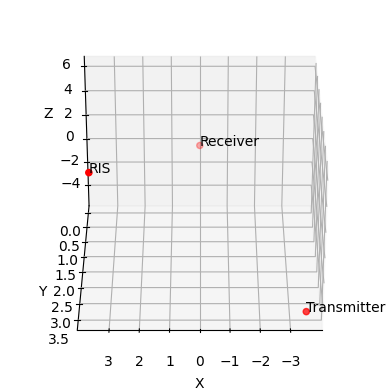

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =  scene.transmitters["tx"].position 
y =  scene.receivers["rx"].position 
z = ris_5x5.position

ax.scatter(x, y, z, c='r', marker='o')

labels = ['Transmitter ', 'Receiver', 'RIS']
for i, label in enumerate(labels):
    ax.text(x[i], y[i], z[i], label)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=30, azim=90)

# Show the plot
plt.show()

Caculate the channel impulse response(CIR) from the attenuation and the delay of each path amidst Tx and Rx using cir_to_ofdm_channel.


It is vital to work with frequency domain rather than time domain because in the latter we have to use convolution, but in the former only multiplication and fft(or ifft) are needed.

In [170]:
tf.random.set_seed(1)
paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True) 
tf.random.set_seed(1)
# LoS only
paths.normalize_delays = False
a, tau = paths.cir(reflection=False, scattering=False)
h_los = cir_to_ofdm_channel(frequencies,a,tau,normalize=False)

tf.random.set_seed(1)
# LoS + scattering and reflection
paths.normalize_delays = False
a, tau = paths.cir(reflection=True, scattering=True)
h_scatterANDref = cir_to_ofdm_channel(frequencies,a,tau,normalize=False)


Since both convolution and multiplication are linear, we can simply add channels to get the total channel between Tx and Rx.

As can be seen, using RIS proved to be helpful in this scene. It is worth mentioning that for a different carrier frequency, RIS location, fft size, RIS gain, number of antennas in Tx/Rx/RIS, or scattering coefficient, the output varies.

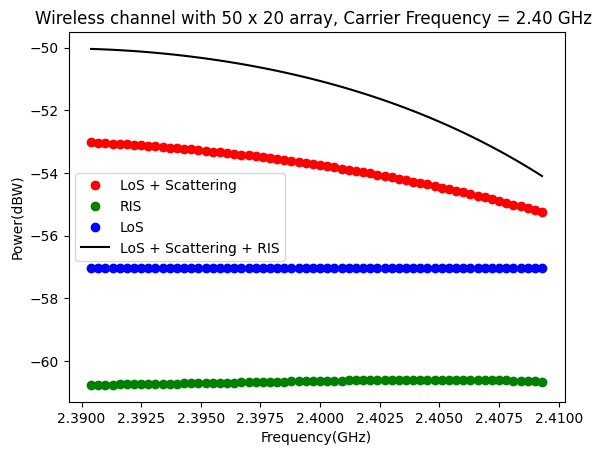

In [171]:
a = h_scatterANDref[0,0,0,0,0,0,:].numpy()
b = h_freq_ris[0,0,0,0,0,0,:].numpy()
c = h_los[0,0,0,0,0,0,:].numpy()
d = a + b

plt.figure();
plt.plot(frequencies/1e9,20*np.log10(tf.abs(a)),'ro',label='LoS + Scattering')
plt.plot(frequencies/1e9,20*np.log10(tf.abs(b)),'go',label = 'RIS')
plt.plot(frequencies/1e9,20*np.log10(tf.abs(c)),'bo',label = 'LoS')
plt.plot(frequencies/1e9,20*np.log10(tf.abs(d)),'k-',label = f'LoS + Scattering + RIS')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Power(dBW)")
plt.title(f"Wireless channel with 50 x 20 array, Carrier Frequency = {(scene.frequency/1e9):0,.2f} GHz ")
plt.legend()

The following plot shows that the phase of channel in the presence of RIS is as same as combination channel of LoS and scattering, which is expected since the phase_optimizer flag on and the environment is not so complex.

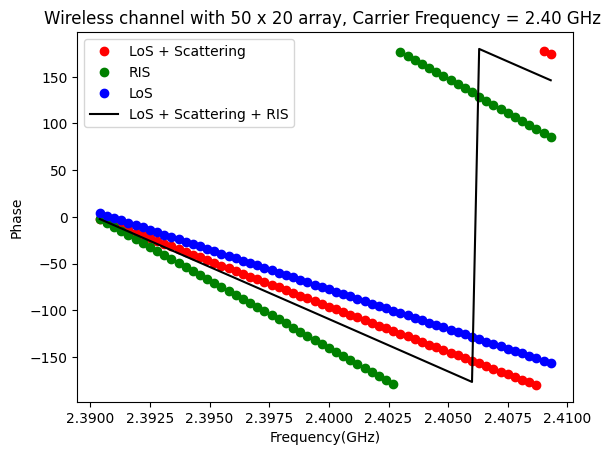

In [172]:
plt.figure();
plt.plot(frequencies/1e9,tf.math.angle(a)*180/PI,'ro',label='LoS + Scattering')
plt.plot(frequencies/1e9,tf.math.angle(b)*180/PI,'go',label = 'RIS')
plt.plot(frequencies/1e9,tf.math.angle(c)*180/PI,'bo',label = 'LoS')
plt.plot(frequencies/1e9,tf.math.angle(d)*180/PI,'k-',label = 'LoS + Scattering + RIS')
plt.xlabel("Frequency(GHz)")
plt.ylabel("Phase")
plt.title(f"Wireless channel with 50 x 20 array, Carrier Frequency = {(scene.frequency/1e9):0,.2f} GHz ")
plt.legend()